In [1]:
from google.colab import files

uploaded = files.upload()

Saving attackdata.json to attackdata.json
Saving testdata.json to testdata.json
Saving testdata2.json to testdata2.json
Saving testdata3.json to testdata3.json
Saving testdata4.json to testdata4.json
Saving testdata5.json to testdata5.json
Saving testdata6.json to testdata6.json
Saving testdata7.json to testdata7.json
Saving testdata8.json to testdata8.json
Saving testdata9.json to testdata9.json
Saving testdata10.json to testdata10.json


In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import torch.nn.functional as F
from tokenizers import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=302a3dd9811306e4cc805ba5c4d1b67dbf8d1d6071488b3da80a4c777d9e6327
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


###Preprocessing and encoding

In [20]:
import json

# Assuming your JSON file is named "data.json"
with open('testdata.json', 'r') as f:
    data = json.load(f)

dataset=data

with open('testdata2.json', 'r') as f:
    data = json.load(f)

dataset+=data
with open('testdata3.json', 'r') as f:
    data = json.load(f)

dataset+=data

with open('testdata4.json', 'r') as f:
    data = json.load(f)

dataset+=data

with open('testdata5.json', 'r') as f:
    data = json.load(f)

dataset+=data
# with open('testdata6.json', 'r') as f:
#     data = json.load(f)

# dataset+=data
with open('testdata7.json', 'r') as f:
    data = json.load(f)

dataset+=data
with open('testdata8.json', 'r') as f:
    data = json.load(f)

dataset+=data
with open('testdata9.json', 'r') as f:
    data = json.load(f)

dataset+=data

In [ ]:
print(dataset[0])

[{'BlockNumber': 15625410, 'TxHash': '0xc5f8f3448ff023c313c35579cc7ae704eef6be113a2edf0226e1171571d41cee', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x5354f00292296518713a47777bb6d2b9712fe74a', 'value': '0.0', 'gas': '0.000000000000168362', 'input': '0x69277b67'}, [[{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000108744', 'input': '0x69277b67'}, [{'to': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000035571', 'input': '0x0c8496cc'}, [{'to': '0x52ae12abe5d8bd778bd5397f99ca900624cfadd4', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000000000002861', 'input': '0xbb34534c42616e636f72466f726d756c61'}, {'to': '0xb1cd6e4153b2a390cf00a6556b0fc1458c4a5533', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.00000

In [4]:
print(len(dataset))
print(dataset[0:10])

def hex_to_float32(hex_value):
    max_value=1e6
    # Remove '0x' prefix if present
    hex_value = hex_value.replace('0x', '')

    if not hex_value:
        hex_value = '0'

    # Convert hexadecimal to decimal
    decimal_value = int(hex_value, 16)

    # Scale down large values
    if decimal_value >= max_value:
        decimal_value = decimal_value%max_value

    # Convert decimal to float32
    float32_value = np.float32(decimal_value)

    return float32_value

def preprocess(dataset):
  flat_dataset = [item for sublist in dataset for item in sublist]


  def store_calls(data):
    calllist=[]
    for cur in data:
      cur['CallList'][1]=cur['CallList'][1][0]
      calllist.append(cur['CallList'])

    return calllist
  print(len(flat_dataset))
  calls=store_calls(flat_dataset)
  print(len(calls))
  def unnest(nested_list, level=0):
      encoded_list = []

      for item in nested_list:
          if isinstance(item, list):
              nested_encoded = unnest(item, level + 1)
              encoded_list.extend(nested_encoded)
          else:
              encoded_list.append(hex_to_float32(item["to"]))
              encoded_list.append(hex_to_float32(item["from"]))
              encoded_list.append(float(item["value"]))
              encoded_list.append(float(item["gas"]))
              encoded_list.append(hex_to_float32(item["input"]))
              encoded_list.append(float(level))

      return encoded_list



  unnested_calls=[]
    # Assuming each sublist in input_list is a sequence
  for seq in calls:
    unnested_calls.append(unnest(seq,0))
  return unnested_calls

unnested_calls=preprocess(dataset)

print(unnested_calls[0:10])

3607
[[{'BlockNumber': 19021452, 'TxHash': '0xc822dc832e14358e8221e05fbff4dda92f7816c7054ccbee4f5e230c72c2efd1', 'CallList': [{'to': '0x3a23f943181408eac424116af7b7790c94cb97a5', 'from': '0x4432e64624f4c64633466655de3d5132ad407343', 'value': '0.0', 'gas': '0.000000000000099842', 'input': '0x'}, [[{'to': '0x789c527a3a756807045ba43ddba3a5b4b65185ec', 'from': '0x3a23f943181408eac424116af7b7790c94cb97a5', 'value': '0.0', 'gas': '0.000000000000086513', 'input': '0x762a8b19'}, [{'to': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 'from': '0x3a23f943181408eac424116af7b7790c94cb97a5', 'value': '0.0', 'gas': '0.000000000000029449', 'input': '0x23b872dd'}, [{'to': '0x43506849d7c04f9138d1a2050bbf3a0c054402dd', 'from': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 'value': '0.0', 'gas': '0.000000000000022154', 'input': '0x23b872dd'}], {'to': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 'from': '0x3a23f943181408eac424116af7b7790c94cb97a5', 'value': '0.0', 'gas': '0.000000000000003448', 'input': '0

In [ ]:
print(dataset[0])

[{'BlockNumber': 15625410, 'TxHash': '0xc5f8f3448ff023c313c35579cc7ae704eef6be113a2edf0226e1171571d41cee', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x5354f00292296518713a47777bb6d2b9712fe74a', 'value': '0.0', 'gas': '0.000000000000168362', 'input': '0x69277b67'}, [{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000108744', 'input': '0x69277b67'}, [{'to': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000035571', 'input': '0x0c8496cc'}, [{'to': '0x52ae12abe5d8bd778bd5397f99ca900624cfadd4', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000000000002861', 'input': '0xbb34534c42616e636f72466f726d756c61'}, {'to': '0xb1cd6e4153b2a390cf00a6556b0fc1458c4a5533', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000

In [ ]:
import csv
csv_file_path = 'bad_contract.csv'

# Pad sequences to the maximum length in the dataset
max_sequence_length = max(len(seq) for seq in unnested_calls)
padded_data = [seq + [-1] * (max_sequence_length - len(seq)) for seq in unnested_calls]

# Write the list to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in padded_data:
        writer.writerow(row)

print(f'CSV file "{csv_file_path}" has been created successfully.')

CSV file "bad_contract.csv" has been created successfully.


In [5]:
import numpy as np
import pandas as pd

minimum=0.0
maximum=0.0

def min_max_normalize(data, min=0.0, max=0.0):
    global minimum
    global maximum
    # Create a copy of the data array
    normalized_data = data.copy()

    # Find indices of non-zero elements
    nonzero_indices = np.where(normalized_data != 0.0)

    # Find the minimum and maximum values in the data (ignoring 0.0)
    if min + max == 0.0:
      print("This is the first normalization")
      min_value = np.min(normalized_data[nonzero_indices])
      max_value = np.max(normalized_data[nonzero_indices])
      minimum = min_value
      maximum = max_value
    else:
      min_value=min
      max_value=max

    # Normalize the non-zero data to be between 0 and 1
    normalized_data[nonzero_indices] = (normalized_data[nonzero_indices] - min_value) / (max_value - min_value)

    return normalized_data

def encode(data, max_length=0):
    # Calculate the maximum length of any column
    if max_length == 0:
      max_length = max(len(col) for col in data)+100

    padded_data = []
    for seq in data:
        if len(seq) > max_length:
            padded_seq = seq[:max_length]  # Truncate if sequence is too long
        else:
            padded_seq = seq + [0.0] * (max_length - len(seq))  # Pad with zeros
        padded_data.append(padded_seq)

    # Convert to numpy array
    print("SIZE")
    print(len(padded_data))
    print(len(padded_data[0]))
    padded_array = np.array(padded_data, dtype=float)

    # # Normalize each column independently
    normalized_array = np.apply_along_axis(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) != np.min(x) else x, axis=0, arr=padded_array)

    if max_length == 0:
      normalized_array = min_max_normalize(padded_array)
    else:
      normalized_array = min_max_normalize(padded_array, minimum, maximum)

    return normalized_array, max_length

# Example usage
input_data, maxL = encode(unnested_calls)
print(input_data)
print(input_data.shape)
print(maximum)
print(minimum)



SIZE
3932
1042
This is the first normalization
[[7.10061444e-01 7.45135689e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.10061444e-01 1.88172043e-02 1.95300588e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.10061444e-01 3.42037890e-01 2.10013441e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.10061444e-01 2.19342038e-01 1.12056174e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.10061444e-01 2.97427035e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.10061444e-01 4.10138249e-01 1.86495948e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(3932, 1042)
999936.0
1.8e-17


In [ ]:
print(type(input_data))

<class 'numpy.ndarray'>


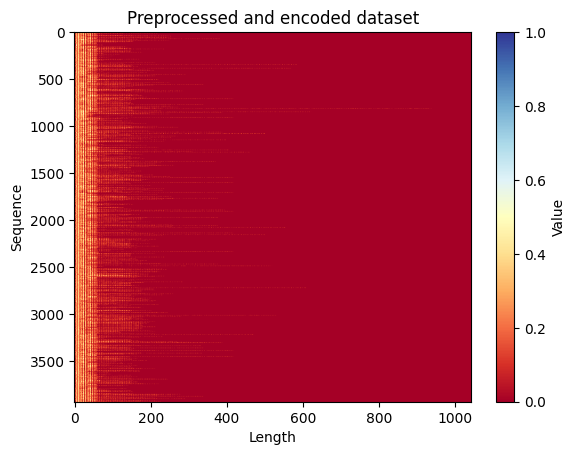

(3932, 1042)


In [6]:
def plot_patterns(data):
  plt.imshow(data, cmap='RdYlBu', aspect='auto')
  plt.colorbar(label='Value')
  plt.title('Preprocessed and encoded dataset')
  plt.xlabel('Length')
  plt.ylabel('Sequence')
  plt.show()


plot_patterns(input_data)
print(input_data.shape)

prep_data=input_data


###DAGMM


Epoch 0/100,TRAIN Loss: 22.6635 - TEST Loss: 12.4247
Epoch 10/100,TRAIN Loss: -0.1317 - TEST Loss: 1.2014
Epoch 20/100,TRAIN Loss: -0.8110 - TEST Loss: -0.1001
Epoch 30/100,TRAIN Loss: -1.0281 - TEST Loss: -0.5997
Epoch 40/100,TRAIN Loss: -1.1043 - TEST Loss: -0.7311
Epoch 50/100,TRAIN Loss: -1.1335 - TEST Loss: -0.7283
Epoch 60/100,TRAIN Loss: -1.1516 - TEST Loss: 3.1524
Epoch 70/100,TRAIN Loss: -1.1754 - TEST Loss: 0.6815
Epoch 80/100,TRAIN Loss: -1.2182 - TEST Loss: -0.9053
Epoch 90/100,TRAIN Loss: -1.2143 - TEST Loss: -0.9773


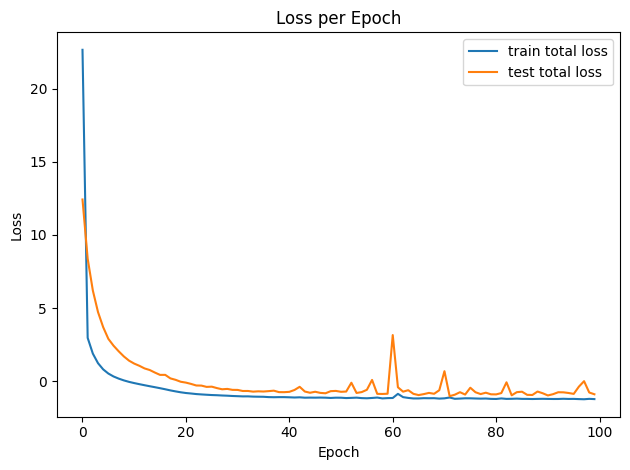

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from torch.autograd import Variable
import tensorflow as tf


# Define Deep Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.Tanh(),
            nn.Linear(hidden_dim3, latent_dim-2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim-2, hidden_dim3),
            nn.Tanh(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

# Define DAGMM Model
class DAGMM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm):
        super(DAGMM, self).__init__()
        self.autoencoder = Autoencoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.estimation_network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim3, n_gmm),
            nn.Softmax(dim=1)
        )
        self.phi = torch.zeros(n_gmm)
        self.mu = torch.zeros(n_gmm,latent_dim)
        self.cov = torch.zeros(n_gmm, latent_dim, latent_dim)
        self.n_gmm=n_gmm
        self.latent_dim=latent_dim

    def relative_euclidean_distance(self, a, b):
        return (a-b).norm(2, dim=1) / a.norm(2, dim=1)

    def compute_cosine_similarity(self, x, x_hat):
        cosine_similarity = F.cosine_similarity(x, x_hat, dim=1)
        return cosine_similarity

    def cov_diag_loss(self):
        cov_inv = torch.zeros(self.cov.size(0), self.cov.size(1), self.cov.size(1), device=self.cov.device)
        det_cov = torch.zeros(self.cov.size(0), device=self.cov.device)
        cov_diag = 0
        for i in range(self.cov.size(0)):
            cov_k = self.cov[i].clone()
            cov_k += torch.diag(torch.full((self.cov.size(1),), 1e-12, device=self.cov.device))
            cov_inv[i] = torch.linalg.inv(cov_k)
            u, s, v = torch.svd(cov_k)
            det_cov[i] = s.prod() ** 2
            cov_diag += torch.sum(1 / cov_k.diag())

        return cov_diag, cov_inv, det_cov


    def forward(self, x):
        z, x_hat = self.autoencoder(x)
        rec_euclidean = self.relative_euclidean_distance(x, x_hat)
        cosine_similarity = self.compute_cosine_similarity(x,x_hat)
        z_with_errors = torch.cat([z, rec_euclidean.unsqueeze(-1), cosine_similarity.unsqueeze(-1)], dim=1)
        gamma = self.estimation_network(z_with_errors)
        return z, x_hat, z_with_errors, gamma


    def compute_energy(self, z):
        cov_diag, cov_inv, det_cov = self.cov_diag_loss()
        z_mu = (z.unsqueeze(1)- self.mu.unsqueeze(0))
        z_mu_cov_inv = torch.sum(z_mu.unsqueeze(-1) * cov_inv.unsqueeze(0), dim=-2)
        exp_term = torch.exp(-0.5 * torch.sum(z_mu_cov_inv * z_mu, dim=-1))
        positive_exp_term = (-0.5 * torch.sum(z_mu_cov_inv * z_mu, dim=-1)).clamp(min=0)
        max_positive_exp_term = torch.max(positive_exp_term, dim=1, keepdim=True)[0]
        energy = -max_positive_exp_term.squeeze() - torch.log(
            torch.sum(self.phi.unsqueeze(0) * exp_term / (torch.sqrt(det_cov)).unsqueeze(0), dim=1) + 1e-12
        )
        return energy



    def loss_function(self, x, lambda_energy, lambda_cov_diag):
        _, x_hat, z, gamma, = self(x)
        N = gamma.size(0)
        sum_gamma = torch.sum(gamma, dim=0)
        if model.training:
          self.phi = (sum_gamma / N)
          self.mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
          z_mu = (z.unsqueeze(1)- self.mu.unsqueeze(0))
          z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
          self.cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        sample_energy = self.compute_energy(z)
        loss = torch.mean((x - x_hat) ** 2) + lambda_energy * torch.mean(sample_energy) + lambda_cov_diag * self.cov_diag_loss()[0]
        return loss

    def get_energy(self, x,  torch_type=True):
        enc, dec, z, gamma = self(x)
        energy = self.compute_energy(z)
        ret_energy=energy.data.numpy()

        if torch_type == True:
          ret_energy=torch.from_numpy(ret_energy)

        return ret_energy


# Hyperparameters
input_dim = len(prep_data[0])
hidden_dim1 = 400
hidden_dim2 = 200
hidden_dim3 = 30
latent_dim = 3
n_gmm = 5
lr = 1e-4
epochs = 100
lambda_energy=0.1
lambda_cov_diag=0.005
batch_size = 60

# Create model and optimizer
model = DAGMM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25, random_state=40)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training function
def train(model, train_loader, test_loader, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_loss_test = 0.0
        running_loss = 0.0
        test_running_loss=0.0
        count=0
        count_test=0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            total_loss = model.loss_function(data, lambda_energy, lambda_cov_diag)
            model.zero_grad()
            total_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            running_loss += total_loss.item()

            loss = []
            loss.append( total_loss.item())
            count+=1
        epoch_loss=running_loss/count
        train_losses.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loader):
                test_loss = model.loss_function(data, lambda_energy, lambda_cov_diag)
                loss = []
                loss.append( test_loss.item())
                test_running_loss += test_loss.item()
                count_test+=1
        epoch_loss_test=test_running_loss/count_test
        test_losses.append(epoch_loss_test)
        if epoch%10 == 0:
          print(f"Epoch {epoch}/{num_epochs},TRAIN Loss: {epoch_loss:.4f} - TEST Loss: {epoch_loss_test:.4f}")
    return train_losses, test_losses


# Plotting function
def plot_losses(loss_data):
    plt.plot(loss_data[0], label="train total loss")
    plt.plot(loss_data[1], label="test total loss")
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    # plt.ylim(loss_data[1][len(loss_data[0])-1]-2,loss_data[1][len(loss_data[0])-1]+2)
    plt.show()



# Train the model
losses = train(model, train_loader, test_loader, optimizer, epochs)

# Test the model
# test_losses = test(model, test_loader)

# avg_test_energy = sum(test_energy) / len(test_energy)

# Plot losses
plot_losses(losses)  # Broadcasting test loss to match training loss length
# print("Average Test Energy: ", avg_test_energy)
# plot_losses(test_losses)

threshold 27.63102149963379
Detected 15 anomalies in test.
Detected 37 anomalies in train.


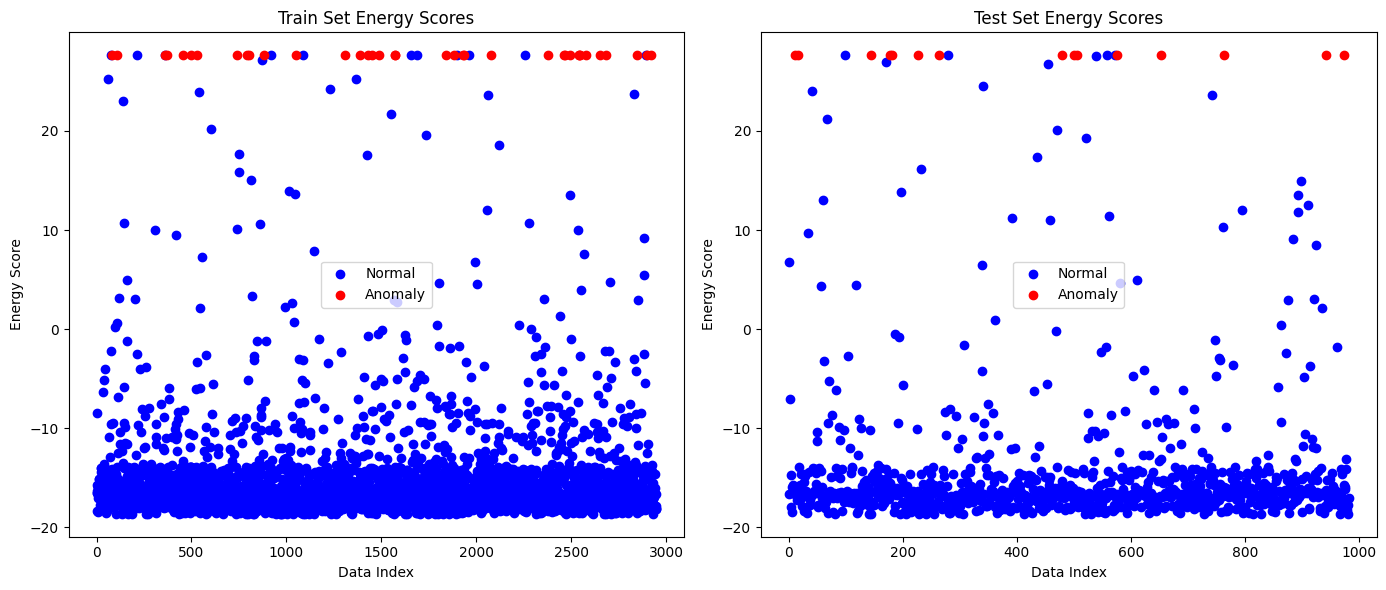

In [8]:
import matplotlib.pyplot as plt

# Compute energy scores for train and test data
train_energy = model.get_energy(train_data)
test_energy = model.get_energy(test_data)

all_energy=np.concatenate((train_energy, test_energy), axis=0)

threshold = np.percentile(all_energy, 99)
print(f"threshold {threshold}")

anomaly_indices_test=torch.where(test_energy >= threshold)[0]

# anomaly_indices = (np.array(eval_energy) > threshold).astype(int)[0]
print(f"Detected {len(anomaly_indices_test)} anomalies in test.")

anomaly_indices_train=torch.where(train_energy >= threshold)[0]

# anomaly_indices = (np.array(eval_energy) > threshold).astype(int)[0]
print(f"Detected {len(anomaly_indices_train)} anomalies in train.")

# Create plots
plt.figure(figsize=(14, 6))

# Train set plot
plt.subplot(1, 2, 1)
normal_train_indices = torch.where(train_energy < threshold)[0]
anomaly_train_indices = torch.where(train_energy >= threshold)[0]
plt.scatter(normal_train_indices, train_energy[normal_train_indices], c='blue', label='Normal')
plt.scatter(anomaly_train_indices, train_energy[anomaly_train_indices], c='red', label='Anomaly')
plt.title('Train Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend()

# Test set plot
plt.subplot(1, 2, 2)
normal_test_indices = torch.where(test_energy < threshold)[0]
anomaly_test_indices = torch.where(test_energy >= threshold)[0]
plt.scatter(normal_test_indices, test_energy[normal_test_indices], c='blue', label='Normal')
plt.scatter(anomaly_test_indices, test_energy[anomaly_test_indices], c='red', label='Anomaly')
plt.title('Test Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend()


plt.tight_layout()
plt.show()

In [9]:
# Find the index of the maximum energy score
max_energy_index = torch.argmax(train_energy)
print(train_energy[torch.argmax(train_energy)])

print("Index of the maximum energy score:", max_energy_index.item())
matching=train_data[max_energy_index]
matching_index = None
for i, node in enumerate(torch.tensor(prep_data, dtype=torch.float)):
    if np.array_equal(node, matching):
        matching_index = i
        break

flat_dataset = [item for sublist in dataset for item in sublist]
print("Index of matching node:", matching_index)
print("in dataset: ", flat_dataset[matching_index])

max_energy_index = torch.argmax(test_energy)
print(test_energy[max_energy_index])

print("Index of the maximum energy score:", max_energy_index.item())
matching=test_data[max_energy_index]
matching_index = None
for i, node in enumerate(torch.tensor(prep_data, dtype=torch.float)):
    if np.array_equal(node, matching):
        matching_index = i
        break

flat_dataset = [item for sublist in dataset for item in sublist]
print("Index of matching node:", matching_index)
print("in dataset: ", flat_dataset[matching_index])

tensor(27.6310)
Index of the maximum energy score: 80
Index of matching node: 1838
in dataset:  {'BlockNumber': 19007058, 'TxHash': '0x74ccf35fb4c2ce784772c137a25414ed3ad02a9c18baeeb8e3bf288326fd197f', 'CallList': [{'to': '0x3a23f943181408eac424116af7b7790c94cb97a5', 'from': '0xe2e1808ed4cc4a6f701696086838f511ee187d57', 'value': '60.0', 'gas': '0.000000000000214816', 'input': '0x'}, [{'to': '0x2d1733886cfd465b0b99f1492f40847495f334c5', 'from': '0x3a23f943181408eac424116af7b7790c94cb97a5', 'value': '0.0', 'gas': '0.00000000000018891', 'input': '0x7d750cf8'}, [{'to': '0x99c9fc46f92e8a1c0dec1b1747d010903e884be1', 'from': '0x3a23f943181408eac424116af7b7790c94cb97a5', 'value': '60.0', 'gas': '0.000000000000175596', 'input': '0x9a2ac6d5'}, [{'to': '0x543ba4aadbab8f9025686bd03993043599c6fb04', 'from': '0x99c9fc46f92e8a1c0dec1b1747d010903e884be1', 'value': '0.0', 'gas': '0.000000000000002347', 'input': '0xb7947262'}, {'to': '0xbfb731cd36d26c2a7287716de857e4380c73a64a', 'from': '0x99c9fc46f92e8

1
1
60
8514
SIZE
1
1042


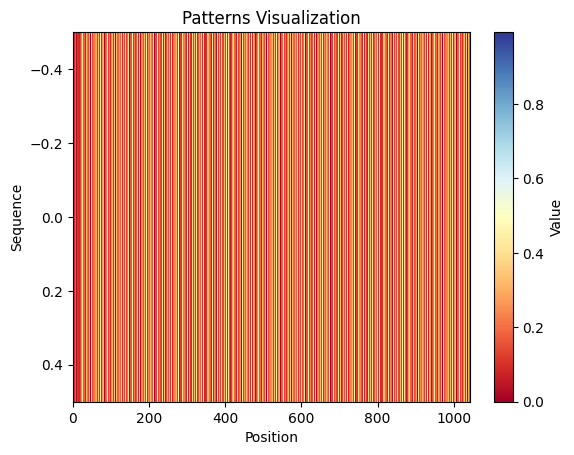

(1, 1042)
eval 1:  tensor([27.6310])


In [10]:
with open('attackdata.json', 'r') as f:
    data = json.load(f)

anomally_dataset=data

anom1 = preprocess(anomally_dataset)

print(len(unnested_calls[0]))
print(len(anom1[0]))
anom_fin,_=encode(anom1, maxL)
anom = torch.tensor(anom_fin, dtype=torch.float)

def plot_patterns(data):
  plt.imshow(data, cmap='RdYlBu', aspect='auto')
  plt.colorbar(label='Value')
  plt.title('Patterns Visualization')
  plt.xlabel('Position')
  plt.ylabel('Sequence')
  plt.gca().yaxis.get_major_locator().set_params(integer=True)
  plt.show()


plot_patterns(anom_fin)
print(anom_fin.shape)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  res1=model.get_energy(anom)


print("eval 1: ", res1)


<class 'torch.Tensor'>
tensor([27.6310])
try again


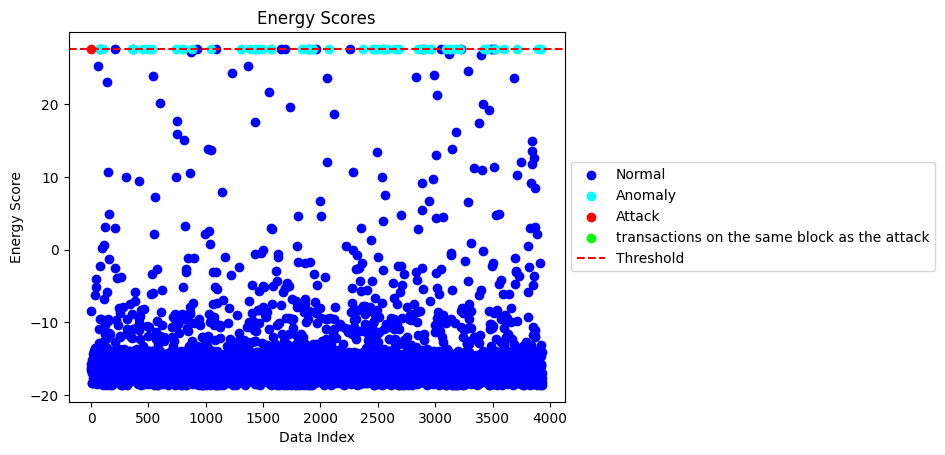

In [11]:
print(type(test_energy))

normal_energy=torch.cat((train_energy, test_energy), dim=0)

normal_indices = torch.where(normal_energy < threshold)[0]
anomaly_indices = torch.where(normal_energy >= threshold)[0]
attack = res1.detach()


plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
print(attack)
plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

if(attack[0]>threshold):
  print("Found you")
else:
  print("try again")


186
186
SIZE
186
1042


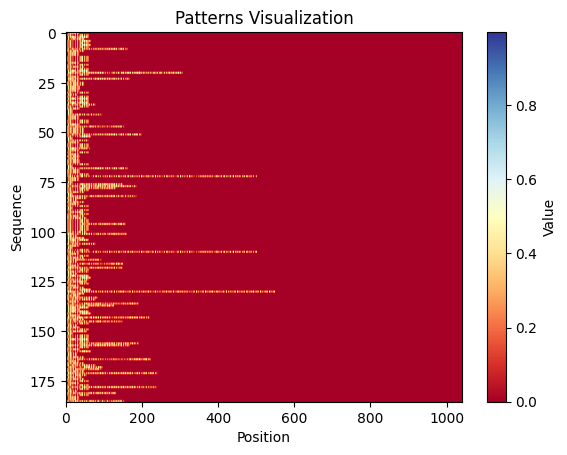

In [12]:
with open('testdata6.json', 'r') as f:
    data = json.load(f)

example_dataset=data

# with open('attackdata.json', 'r') as f:
#     data = json.load(f)

# example_dataset+=[data]


exam1 = preprocess(example_dataset)

exam_fin, _=encode(exam1, maxL)
exam = torch.tensor(exam_fin, dtype=torch.float)



plot_patterns(exam_fin)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  res2=model.get_energy(exam)



[]

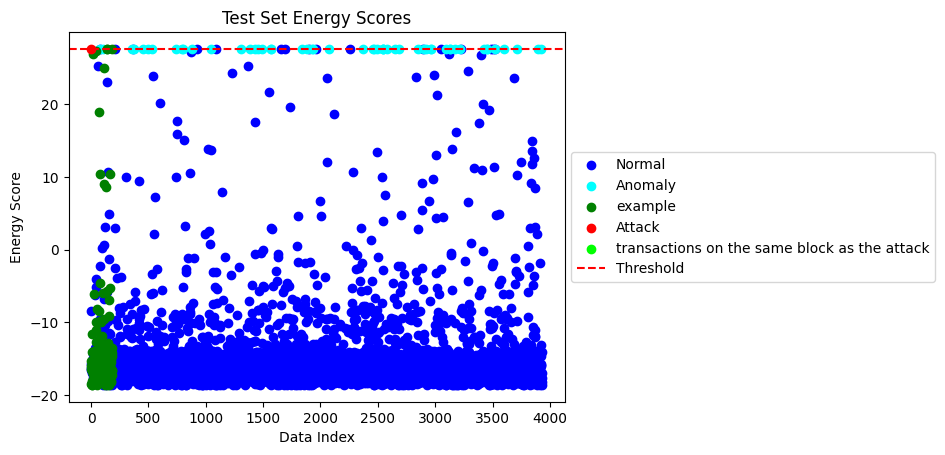

In [13]:
example = res2.detach()

plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
plt.scatter(range(len(example)), example, c='green', label='example')

plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Test Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.plot()


In [14]:
max_energy_index = torch.argmax(example)
print("Index of the maximum energy score:", max_energy_index.item())
matching=example[max_energy_index].item()
matching_index = None
# for i, node in enumerate(torch.tensor(exam_fin, dtype=torch.float)):
#     if np.array_equal(node, matching):
#         matching_index = i
#         break

flat_dataset = [item for sublist in example_dataset for item in sublist]
print("Energy found:", matching)
if matching != None:
  print("in dataset: ", flat_dataset[max_energy_index])

Index of the maximum energy score: 136
Energy found: 27.63102149963379
in dataset:  {'BlockNumber': 19005132, 'TxHash': '0xe938bdd3bfe2157a2b70f01a2c4c87e4b111921bf2b564123d9db9a5d4b31354', 'CallList': [{'to': '0x0439e60f02a8900a951603950d8d4527f400c3f1', 'from': '0xb10bd34199663ebfbf20d740959d773e34030b59', 'value': '0.0', 'gas': '0.000000000000336315', 'input': '0x3ce33bff'}, [{'to': '0xd9c2d319cd7e6177336b0a9c93c21cb48d84fb54', 'from': '0x0439e60f02a8900a951603950d8d4527f400c3f1', 'value': '0.0', 'gas': '0.000000000000039639', 'input': '0x23b872dd'}, {'to': '0x9a47f3289794e9bbc6a3c571f6d96ad4e7baed16', 'from': '0x0439e60f02a8900a951603950d8d4527f400c3f1', 'value': '0.0', 'gas': '0.000000000000323076', 'input': '0x4cfee326'}, [{'to': '0x7ac070f096c6e20931c3dc54f927446be232618b', 'from': '0x9a47f3289794e9bbc6a3c571f6d96ad4e7baed16', 'value': '0.0', 'gas': '0.000000000000316248', 'input': '0xab13824'}, [{'to': '0xd9c2d319cd7e6177336b0a9c93c21cb48d84fb54', 'from': '0x9a47f3289794e9bbc6a

In [ ]:
def print_metrics(threshold, train_energy, test_energy, attack, example):

  print("the attack is found by the model: ", (attack[0] >= threshold).item())
  print("The threshold is: ", threshold)
  print("The energy value of the attack is: ", attack[0])
  print("the highest energy in train is: ", train_energy[torch.argmax(train_energy)])
  print("the highest energy in test is: ", test_energy[torch.argmax(test_energy)])
  print("the highest energy in example is: ", example[torch.argmax(example)])

  print("------------------")

  print("number of transactions with energy greater or equal to the threshold in train is: ", len(torch.where(train_energy >= threshold)[0]), " out of: ", len(train_energy))
  print("number of transactions with energy greater or equal to the threshold in test is: ", len(torch.where(test_energy >= threshold)[0]), " out of: ", len(test_energy))
  print("number of transactions with energy greater or equal to the threshold in example is: ", len(torch.where(example >= threshold)[0]), " out of: ", len(example))

  print("------------------")

  print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(train_energy >= attack[0])[0]), " out of: ", len(train_energy))
  print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(test_energy >= attack[0])[0]), " out of: ", len(test_energy))
  print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example >= attack[0])[0]), " out of: ", len(example))

  print("------------------")

  print("average energy value in train is: ",torch.mean(train_energy))
  print("average energy value in test is: ",torch.mean(test_energy))
  print("average energy value in example is: ",torch.mean(example))

print_metrics(threshold, train_energy, test_energy, attack, example)

the attack is found by the model:  True
The threshold is:  -7.164126992225578
The energy value of the attack is:  tensor(27.6309)
the highest energy in train is:  tensor(26.9144)
the highest energy in test is:  tensor(9.7643)
the highest energy in example is:  tensor(27.6147)
------------------
number of transactions with energy greater or equal to the threshold in train is:  25  out of:  2575
number of transactions with energy greater or equal to the threshold in test is:  10  out of:  859
number of transactions with energy greater or equal to the threshold in example is:  7  out of:  186
------------------
number of transactions with energy greater or equal to the attack in train is:  0  out of:  2575
number of transactions with energy greater or equal to the attack in test is:  0  out of:  859
number of transactions with energy greater or equal to the attack in example is:  0  out of:  186
------------------
average energy value in train is:  tensor(-18.2384)
average energy value in

###True False

In i=  0
Epoch 0/100,TRAIN Loss: 43.0360 - TEST Loss: 7.5983
Epoch 10/100,TRAIN Loss: 0.0179 - TEST Loss: 0.0860
Epoch 20/100,TRAIN Loss: -0.5980 - TEST Loss: -0.3990
Epoch 30/100,TRAIN Loss: -0.8824 - TEST Loss: -0.6077
Epoch 40/100,TRAIN Loss: -0.9655 - TEST Loss: -0.7074
Epoch 50/100,TRAIN Loss: -1.0249 - TEST Loss: -0.4131
Epoch 60/100,TRAIN Loss: -1.0144 - TEST Loss: -0.9278
Epoch 70/100,TRAIN Loss: -1.0162 - TEST Loss: -1.0014
Epoch 80/100,TRAIN Loss: -0.6828 - TEST Loss: -0.3285
Epoch 90/100,TRAIN Loss: -1.0418 - TEST Loss: -0.9158


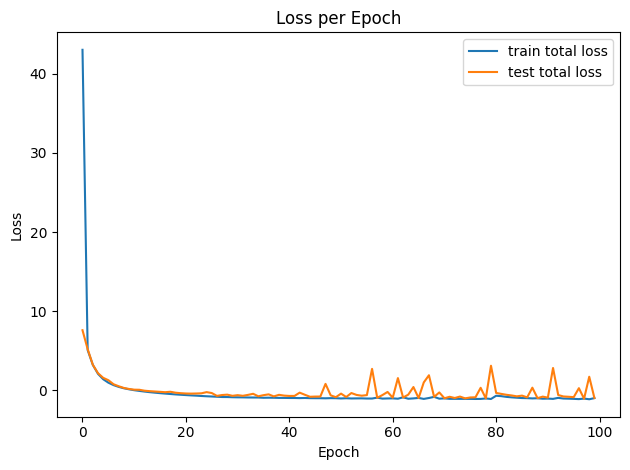

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.9301075268817204
False possitive:  0.06989247311827956
False negative:  0.0
True possitive:  1.0
True negative:  0.9032258064516129
False possitive:  0.0967741935483871
False negative:  0.0
True possitive:  1.0
True negative:  0.7311827956989247
False possitive:  0.26881720430107525
False negative:  0.0
In i=  1
Epoch 0/100,TRAIN Loss: 44.7457 - TEST Loss: 15.4448
Epoch 10/100,TRAIN Loss: 0.3312 - TEST Loss: -0.0269
Epoch 20/100,TRAIN Loss: -0.6475 - TEST Los

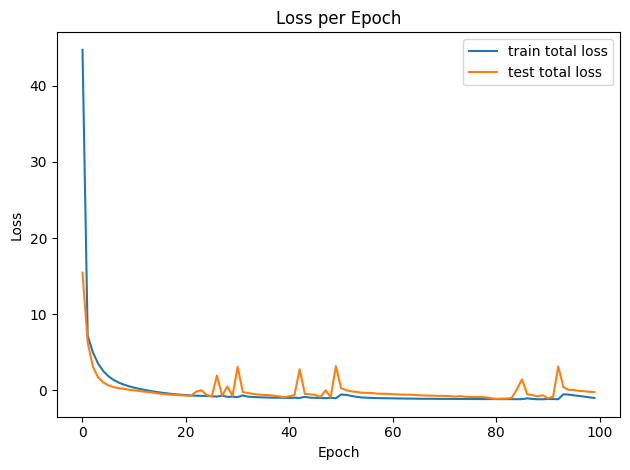

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  0.0
True negative:  0.9946236559139785
False possitive:  0.005376344086021506
False negative:  1.0
True possitive:  0.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  1.0
True possitive:  0.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  1.0
True possitive:  0.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  1.0
True possitive:  0.0
True negative:  0.9408602150537635
False possitive:  0.05913978494623656
False negative:  1.0
True possitive:  0.0
True negative:  0.9032258064516129
False possitive:  0.0967741935483871
False negative:  1.0
True possitive:  1.0
True negative:  0.7526881720430108
False possitive:  0.24731182795698925
False negative:  0.0
In i=  2
Epoch 0/100,TRAIN Loss: 29.4157 - TEST Loss: 3.3570
Epoch 10/100,TRAIN Loss: 0.3996 - TEST Loss: -0.0028
Epoch 20/100,TRAIN Loss: -0.2921 - TEST Lo

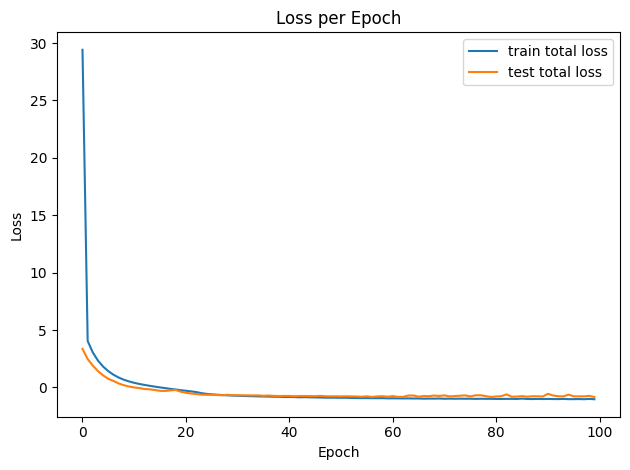

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9946236559139785
False possitive:  0.005376344086021506
False negative:  0.0
True possitive:  1.0
True negative:  0.9946236559139785
False possitive:  0.005376344086021506
False negative:  0.0
True possitive:  1.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  0.0
True possitive:  1.0
True negative:  0.967741935483871
False possitive:  0.03225806451612903
False negative:  0.0
True possitive:  1.0
True negative:  0.9086021505376344
False possitive:  0.0913978494623656
False negative:  0.0
True possitive:  1.0
True negative:  0.8763440860215054
False possitive:  0.12365591397849462
False negative:  0.0
True possitive:  1.0
True negative:  0.7150537634408602
False possitive:  0.2849462365591398
False negative:  0.0
In i=  3
Epoch 0/100,TRAIN Loss: 29.0006 - TEST Loss: 5.5521
Epoch 10/100,TRAIN Loss: -0.0886 - TEST Loss: -0.4009
Epoch 20/100,TRAIN Loss: -0.7140 - TEST Los

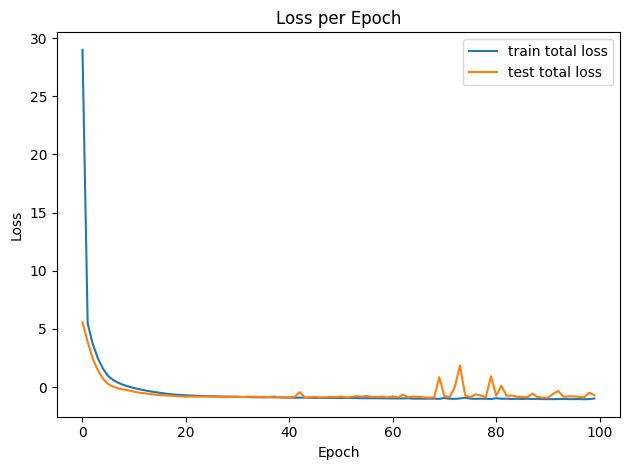

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  0.0
True negative:  1.0
False possitive:  0.0
False negative:  1.0
True possitive:  1.0
True negative:  0.9946236559139785
False possitive:  0.005376344086021506
False negative:  0.0
True possitive:  1.0
True negative:  0.967741935483871
False possitive:  0.03225806451612903
False negative:  0.0
True possitive:  1.0
True negative:  0.967741935483871
False possitive:  0.03225806451612903
False negative:  0.0
True possitive:  1.0
True negative:  0.9354838709677419
False possitive:  0.06451612903225806
False negative:  0.0
True possitive:  1.0
True negative:  0.8870967741935484
False possitive:  0.11290322580645161
False negative:  0.0
True possitive:  1.0
True negative:  0.6720430107526881
False possitive:  0.3279569892473118
False negative:  0.0
In i=  4
Epoch 0/100,TRAIN Loss: 56.2087 - TEST Loss: 4.3957
Epoch 10/100,TRAIN Loss: 1.4040 - TEST Loss: 0.4538
Epoch 20/100,TRAIN Loss: 0.1201 - TEST Loss: -0.1098
Epoch 30/100,TRAIN Loss:

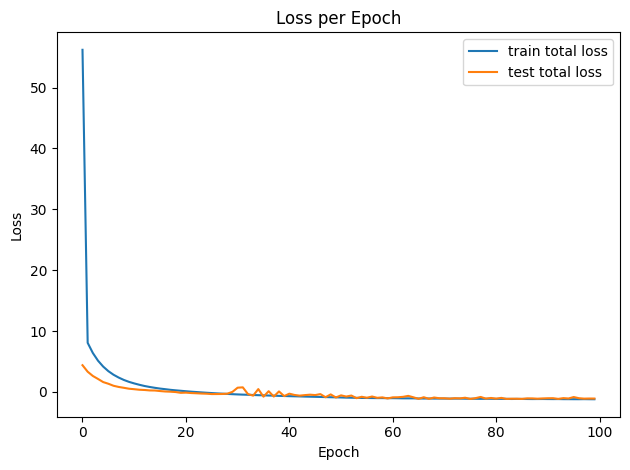

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.956989247311828
False possitive:  0.043010752688172046
False negative:  0.0
True possitive:  1.0
True negative:  0.9086021505376344
False possitive:  0.0913978494623656
False negative:  0.0
True possitive:  1.0
True negative:  0.8548387096774194
False possitive:  0.14516129032258066
False negative:  0.0
True possitive:  1.0
True negative:  0.7311827956989247
False possitive:  0.26881720430107525
False negative:  0.0
In i=  5
Epoch 0/100,TRAIN Loss: 19.4457 - TEST Loss: 13.2545
Epoch 10/100,TRAIN Loss: -0.2121 - TEST Loss: 2.4325
Epoch 20/100,TRAIN Loss: -0.8639 - TEST 

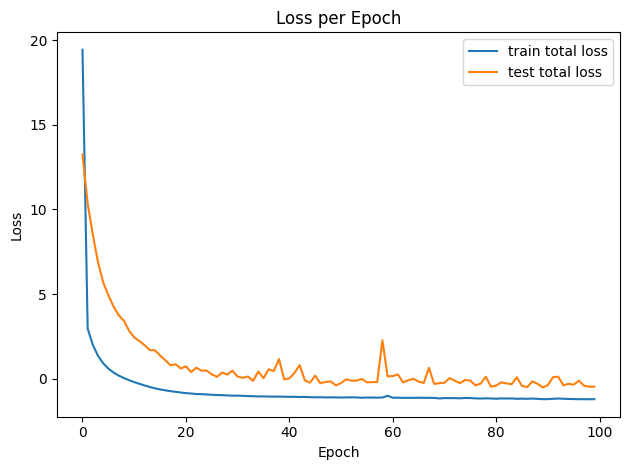

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9408602150537635
False possitive:  0.05913978494623656
False negative:  0.0
True possitive:  1.0
True negative:  0.9247311827956989
False possitive:  0.07526881720430108
False negative:  0.0
True possitive:  1.0
True negative:  0.7688172043010753
False possitive:  0.23118279569892472
False negative:  0.0
In i=  6
Epoch 0/100,TRAIN Loss: 39.9820 - TEST Loss: 9.5171
Epoch 10/100,TRAIN Loss: 0.5883 - TEST Loss: 0.9307
Epoch 20/100,TRAIN Loss: -0.1247 - TEST 

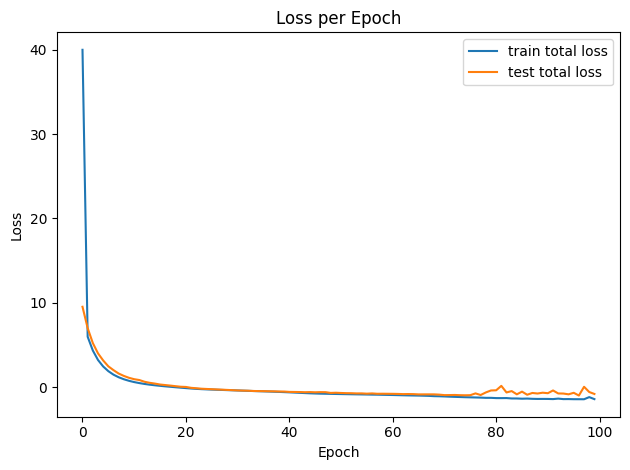

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.8817204301075269
False possitive:  0.11827956989247312
False negative:  0.0
True possitive:  1.0
True negative:  0.8817204301075269
False possitive:  0.11827956989247312
False negative:  0.0
True possitive:  1.0
True negative:  0.8817204301075269
False possitive:  0.11827956989247312
False negative:  0.0
True possitive:  1.0
True negative:  0.8817204301075269
False possitive:  0.11827956989247312
False negative:  0.0
True possitive:  1.0
True negative:  0.8817204301075269
False possitive:  0.11827956989247312
False negative:  0.0
True possitive:  1.0
True negative:  0.8817204301075269
False possitive:  0.11827956989247312
False negative:  0.0
True possitive:  1.0
True negative:  0.7741935483870968
False possitive:  0.22580645161290322
False negative:  0.0
In i=  7
Epoch 0/100,TRAIN Loss: 26.9473 - TEST Loss: 2.8802
Epoch 10/100,TRAIN Loss: 0.2131 - TEST Loss: -0.4597
Epoch 20/100,TRAIN Loss: -0.5894 - TEST Los

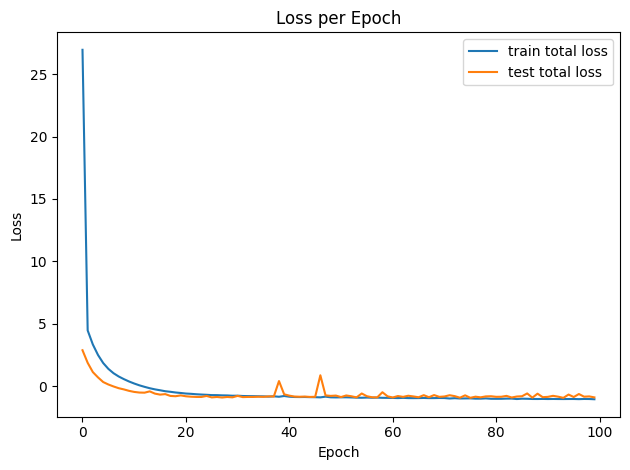

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.967741935483871
False possitive:  0.03225806451612903
False negative:  0.0
True possitive:  1.0
True negative:  0.9516129032258065
False possitive:  0.04838709677419355
False negative:  0.0
True possitive:  1.0
True negative:  0.8924731182795699
False possitive:  0.10752688172043011
False negative:  0.0
True possitive:  1.0
True negative:  0.8548387096774194
False possitive:  0.14516129032258066
False negative:  0.0
True possitive:  1.0
True negative:  0.7419354838709677
False possitive:  0.25806451612903225
False negative:  0.0
In i=  8
Epoch 0/100,TRAIN Loss: 20.4518 - TEST Loss: 6.5608
Epoch 10/100,TRAIN Loss: -0.1817 - TEST Loss: -0.0852
Epoch 20/100,TRAIN Loss: -0.7381 - TEST L

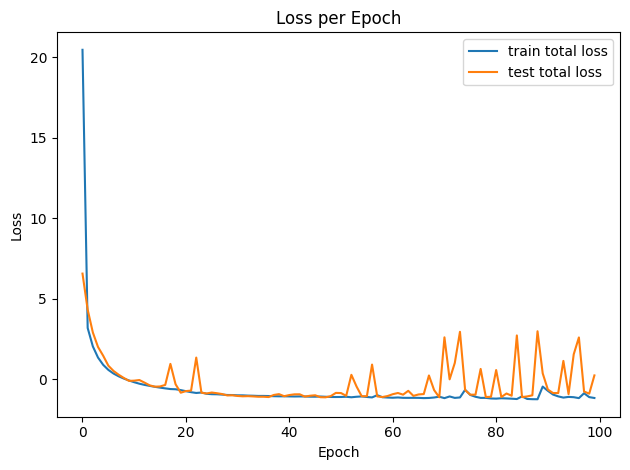

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9516129032258065
False possitive:  0.04838709677419355
False negative:  0.0
True possitive:  1.0
True negative:  0.9516129032258065
False possitive:  0.04838709677419355
False negative:  0.0
True possitive:  1.0
True negative:  0.9516129032258065
False possitive:  0.04838709677419355
False negative:  0.0
True possitive:  1.0
True negative:  0.9516129032258065
False possitive:  0.04838709677419355
False negative:  0.0
True possitive:  1.0
True negative:  0.9247311827956989
False possitive:  0.07526881720430108
False negative:  0.0
True possitive:  1.0
True negative:  0.8870967741935484
False possitive:  0.11290322580645161
False negative:  0.0
True possitive:  1.0
True negative:  0.7365591397849462
False possitive:  0.26344086021505375
False negative:  0.0
In i=  9
Epoch 0/100,TRAIN Loss: 30.9324 - TEST Loss: 8.2649
Epoch 10/100,TRAIN Loss: 0.0366 - TEST Loss: 0.1904
Epoch 20/100,TRAIN Loss: -0.6237 - TEST Loss

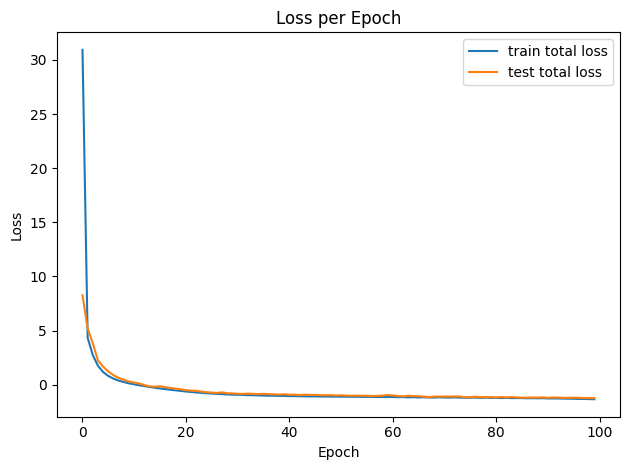

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  0.0
True possitive:  1.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  0.0
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.9623655913978495
False possitive:  0.03763440860215054
False negative:  0.0
True possitive:  1.0
True negative:  0.8978494623655914
False possitive:  0.10215053763440861
False negative:  0.0
True possitive:  1.0
True negative:  0.8709677419354839
False possitive:  0.12903225806451613
False negative:  0.0
True possitive:  1.0
True negative:  0.7419354838709677
False possitive:  0.25806451612903225
False negative:  0.0

Results after 10 model trains
_____________________________
For threshold =  0.01
False possitive:  0.8
True possitive:  0.025806451612903226
False negative

In [15]:
input_dim = len(prep_data[0])
hidden_dim1 = 400
hidden_dim2 = 200
hidden_dim3 = 30
latent_dim = 3
n_gmm = 5
lr = 1e-4
epochs = 100
lambda_energy=0.1
lambda_cov_diag=0.005
batch_size = 60

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

def stats(example, attack, threshold):
  res=[]
  for thres in threshold:
    false_pos=len(torch.where(example >= thres)[0])/len(example)
    true_pos=len(torch.where(attack >= thres)[0])/len(attack)
    false_neg=len(torch.where(attack < thres)[0])/len(attack)
    true_neg=len(torch.where(example < thres)[0])/len(example)
    res.append([true_pos, true_neg, false_pos, false_neg])

  return res



def train_model(model, prep_data, optimizer, epochs):
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


  losses = train(model, train_loader, test_loader, optimizer, epochs)
  plot_losses(losses)
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    train_energy = model.get_energy(train_data)
    test_energy = model.get_energy(test_data)

    all_energy=np.concatenate((train_energy, test_energy), axis=0)

    threshold = [np.percentile(all_energy, 99.99),np.percentile(all_energy, 99.9),np.percentile(all_energy, 99.5),np.percentile(all_energy, 99),np.percentile(all_energy, 95),np.percentile(all_energy, 90),np.percentile(all_energy, 75)]

    with open('testdata6.json', 'r') as f:
      data = json.load(f)

    example_dataset=data
    exam1 = preprocess(example_dataset)
    exam_fin, _=encode(exam1, maxL)
    exam = torch.tensor(exam_fin, dtype=torch.float)
    res2=model.get_energy(exam)
    example = res2.detach()
    with open('attackdata.json', 'r') as f:
      data = json.load(f)
    anomally_dataset=data
    anom1 = preprocess(anomally_dataset)
    anom_fin,_=encode(anom1, maxL)
    anom = torch.tensor(anom_fin, dtype=torch.float)
    res1=model.get_energy(anom)
    attack = res1.detach()

    ftpn=stats(example, torch.tensor([attack[0]], dtype=torch.float), threshold)
    return ftpn
i=0
while(i<10):
  print("In i= ", i)
  model = DAGMM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  results = train_model(model, prep_data, optimizer, epochs)
  count=0
  for res in results:
    print("True possitive: ", res[0])
    print("True negative: ", res[1])
    print("False possitive: ", res[2])
    print("False negative: ", res[3])
    true_pos_arr[count].append(res[0])
    true_neg_arr[count].append(res[1])
    false_pos_arr[count].append(res[2])
    false_neg_arr[count].append(res[3])
    count+=1
  i+=1
thresholds=[0.01, 0.1, 0.5, 1, 5, 10, 25]
print()
print("Results after 10 model trains")
print("_____________________________")
count=0
for tr in thresholds:
  print("For threshold = ", tr)
  print("False possitive: ", mean(true_pos_arr[count]))
  print("True possitive: ", mean(false_pos_arr[count]))
  print("False negative: ", mean(true_neg_arr[count]))
  print("True negative: ", mean(false_neg_arr[count]))
  count+=1




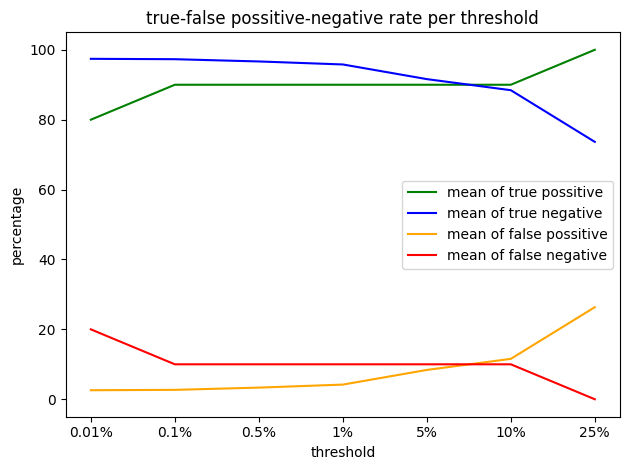

In [16]:
  mtp=[]
  mfp=[]
  mtn=[]
  mfn=[]
  t=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
  count=0
  for tr in thresholds:
    mtp.append(mean(true_pos_arr[count])*100)
    mtn.append(mean(true_neg_arr[count])*100)
    mfp.append(mean(false_pos_arr[count])*100)
    mfn.append(mean(false_neg_arr[count])*100)
    count+=1

  plt.plot(t, mtp, label="mean of true possitive", c='green')
  plt.plot(t, mtn, label="mean of true negative", c='blue')
  plt.plot(t, mfp, label="mean of false possitive", c='orange')
  plt.plot(t, mfn, label="mean of false negative", c='red')
  plt.title('true-false possitive-negative rate per threshold')
  plt.xlabel('threshold')
  plt.ylabel('percentage')
  plt.legend()
  plt.tight_layout()
  # plt.ylim(loss_data[1][len(loss_data[0])-1]-2,loss_data[1][len(loss_data[0])-1]+2)
  plt.show()


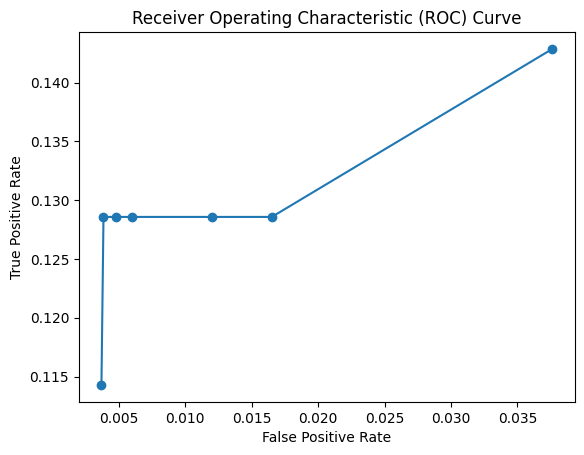

In [17]:

total_positives = sum(mtp) + sum(mfn)
total_negatives = sum(mtn) + sum(mfp)

# Calculate TPR and FPR
TPR = [tp / total_positives for tp in mtp]
FPR = [fp / total_negatives for fp in mfp]

# Plotting the ROC curve
plt.plot(FPR, TPR, marker='o')


# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Displaying the plot
plt.show()

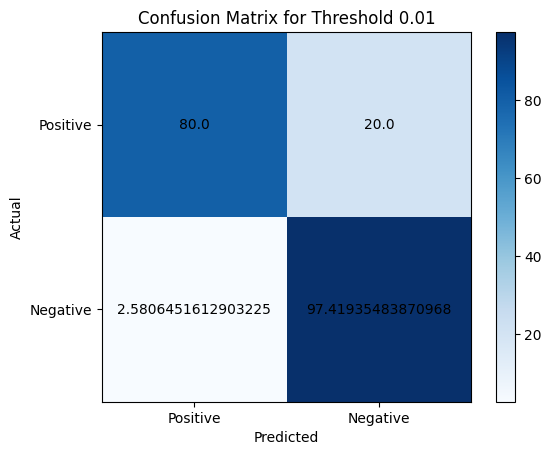

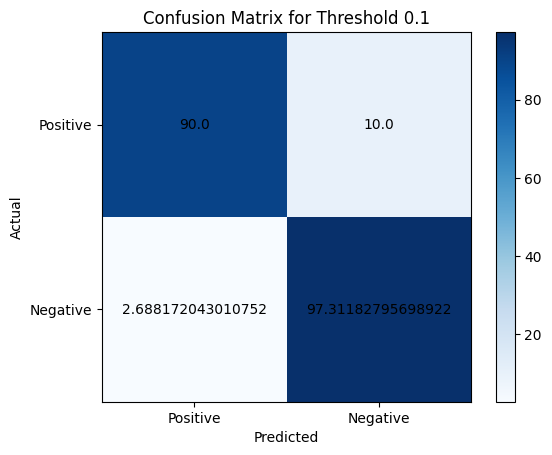

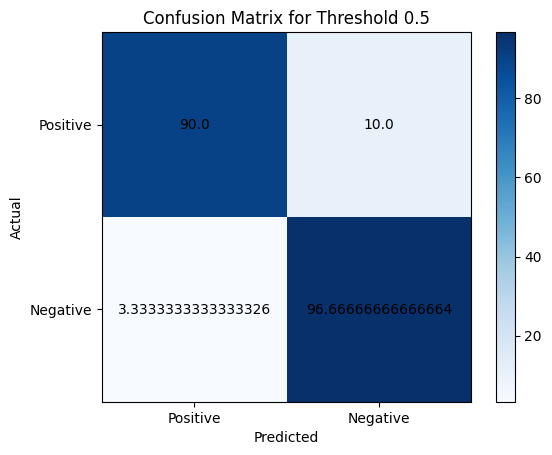

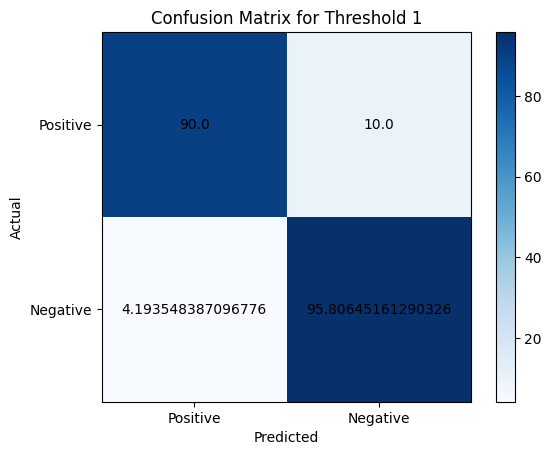

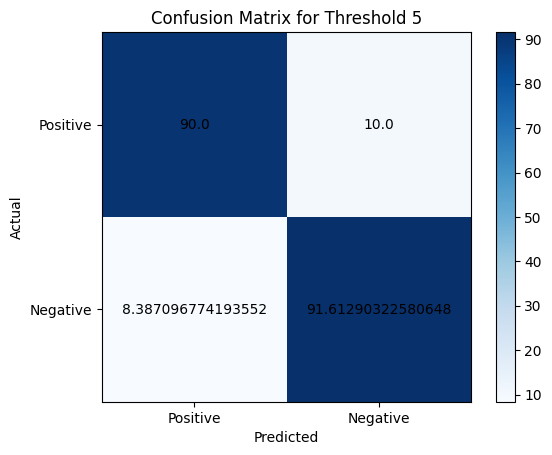

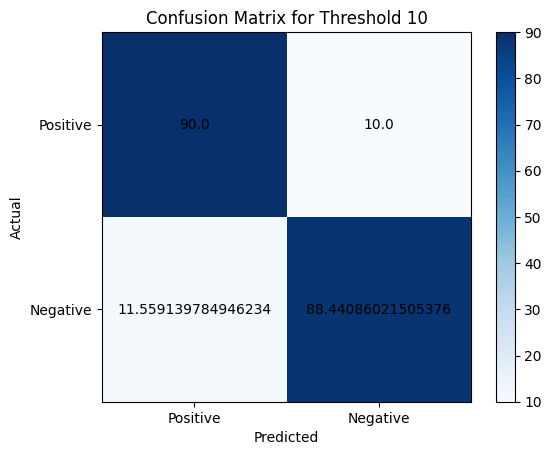

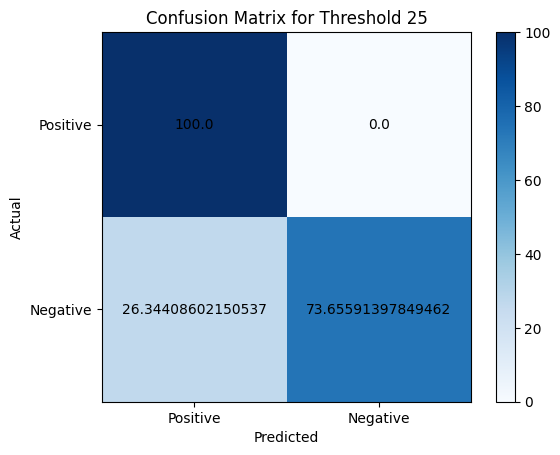

In [18]:
# Sample percentages of TP, TN, FP, FN for different thresholds


for i, threshold in enumerate(thresholds):

    total_positives = mtp[i] + mfn[i]
    total_negatives = mtn[i] + mfp[i]

    # Calculate TP, TN, FP, FN
    TP = mtp[i] / 100 * total_positives
    TN = mtn[i] / 100 * total_negatives
    FP = mfp[i] / 100 * total_negatives
    FN = mfn[i] / 100 * total_positives

    # Creating confusion matrix
    confusion_matrix = np.array([[TP, FN], [FP, TN]])

    # Plotting the confusion matrix
    plt.figure()
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # Adding labels
    plt.title(f'Confusion Matrix for Threshold {threshold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks([0, 1], ['Positive', 'Negative'])
    plt.yticks([0, 1], ['Positive', 'Negative'])

    # Displaying the plot
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            plt.text(j, i, str(confusion_matrix[i, j]), va='center', ha='center')

plt.show()


###Isolation Forest


In [22]:
with open('testdata6.json', 'r') as f:
  data = json.load(f)

example_dataset=data
exam1 = preprocess(example_dataset)
exam_fin, _=encode(exam1, maxL)
exam = torch.tensor(exam_fin, dtype=torch.float)

with open('attackdata.json', 'r') as f:
  data = json.load(f)
anomally_dataset=data
anom1 = preprocess(anomally_dataset)
anom_fin,_=encode(anom1, maxL)
anom = torch.tensor(anom_fin, dtype=torch.float)


186
186
SIZE
186
1042
1
1
SIZE
1
1042


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

# Assuming prep_data is your dataset
# Splitting data into train and test sets
clf = IsolationForest(contamination=0.01, max_samples='auto', max_features = 1000 , n_estimators=1000, bootstrap=False)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25, random_state=40)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.5
true positive:  0.0
false positive:  0.016129032258064516
true negative:  0.9838709677419355
false negative:  1.0
for threshold:  1
true positive:  1.0
false positive:  0.016129032258064516
true negative:  0.9838709677419355
false negative:  0.0
for threshold:  5
true positive:  1.0
false positive:  0.06989247311827956
true negative:  0.9301075268817204
false negative:  0.0
for threshold:  10
true positive:  1.0
false positive:  0.12365591397849462
true negative:  0.8763440860215054
false negative:  0.0
for threshold:  25
true positive:  1.0
false positive:  0.23655913978494625
true negative:  0.7634408602150538
false negative:  0.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold: 

###One class SVM

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)  # You can adjust the nu parameter as needed

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1

in i= 0
for threshold:  0.01
true positive:  1.0
false positive:  0.0
true negative:  1.0
false negative:  0.0
for threshold:  0.1
true positive:  1.0
false positive:  0.005376344086021506
true negative:  0.9946236559139785
false negative:  0.0
for threshold:  0.5
true positive:  1.0
false positive:  0.010752688172043012
true negative:  0.989247311827957
false negative:  0.0
for threshold:  1
true positive:  1.0
false positive:  0.03225806451612903
true negative:  0.967741935483871
false negative:  0.0
for threshold:  5
true positive:  1.0
false positive:  0.053763440860215055
true negative:  0.946236559139785
false negative:  0.0
for threshold:  10
true positive:  1.0
false positive:  0.12365591397849462
true negative:  0.8763440860215054
false negative:  0.0
for threshold:  25
true positive:  1.0
false positive:  0.25806451612903225
true negative:  0.7419354838709677
false negative:  0.0
in i= 1
for threshold:  0.01
true positive:  1.0
false positive:  0.0
true negative:  1.0
false n

###SGD One Class SVM

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split

# Assuming prep_data is your dataset
# Splitting data into train and test sets

# Create One-Class SVM model
clf = SGDOneClassSVM(nu=0.01, learning_rate='optimal', average=True)  # You can adjust the nu parameter as needed

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.5
true positive:  0.0
false positive:  0.010752688172043012
true negative:  0.989247311827957
false negative:  1.0
for threshold:  1
true positive:  0.0
false positive:  0.026881720430107527
true negative:  0.9731182795698925
false negative:  1.0
for threshold:  5
true positive:  0.0
false positive:  0.07526881720430108
true negative:  0.9247311827956989
false negative:  1.0
for threshold:  10
true positive:  0.0
false positive:  0.11290322580645161
true negative:  0.8870967741935484
false negative:  1.0
for threshold:  25
true positive:  0.0
false positive:  0.2849462365591398
true negative:  0.7150537634408602
false negative:  1.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0

###Autoencoder

In [26]:
import torch.nn as nn
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

class AE(nn.Module):
    def __init__(self, input_dim):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.Tanh(),
            nn.Linear(400, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 25),
            nn.Tanh(),
            nn.Linear(25, 12),
        )
        self.dec = nn.Sequential(
            nn.Linear(12, 25),
            nn.Tanh(),
            nn.Linear(25, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 200),
            nn.Tanh(),
            nn.Linear(200, 400),
            nn.Tanh(),
            nn.Linear(400, input_dim),
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

lr = 6.0         # learning rate
w_d = 1e-4        # weight decay
epochs = 100

prep_data_tensor = torch.tensor(prep_data, dtype=torch.float32)
input_dim = prep_data_tensor.shape[1]
model = AE(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(prep_data_tensor, test_size=0.25)
  train_losses = []
  test_losses = []
  for epoch in range(epochs):
      # Forward pass and compute training loss
      model.train()
      sample = model(train_data)
      train_loss = criterion(train_data, sample)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      # Compute testing loss
      model.eval()
      with torch.no_grad():
          test_outputs = model(test_data)
          test_loss = criterion(test_outputs, test_data)

      # Print progress and store losses
      if (epoch+1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

  def reconstruction_loss(input_data, output_data):
      return torch.mean((input_data - output_data)**2, axis=1)


  # Calculate reconstruction error for each data point in the test set
  def get_energy(data):
    with torch.no_grad():
        reconstructed_data = model(data)
        reconstruction_errors = reconstruction_loss(data, reconstructed_data).detach().numpy()
    return reconstruction_errors

  # Get anomaly scores for test data
  test_energy=get_energy(train_data)
  train_energy=get_energy(test_data)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, 100-th)

    normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

    normal_indices = torch.where(normal_energy < threshold)[0]
    anomaly_indices = torch.where(normal_energy >= threshold)[0]
    attack = torch.tensor(get_energy(anom))
    example = torch.tensor(get_energy(exam))

    false_pos=len(torch.where(example >= threshold)[0])/len(example)
    true_pos=len(torch.where(attack >= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack < threshold)[0])/len(attack)
    true_neg=len(torch.where(example < threshold)[0])/len(example)

    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


Epoch [10/100], Train Loss: 0.0093, Test Loss: 0.0097
Epoch [20/100], Train Loss: 0.0073, Test Loss: 0.0077
Epoch [30/100], Train Loss: 0.0062, Test Loss: 0.0066
Epoch [40/100], Train Loss: 0.0057, Test Loss: 0.0062
Epoch [50/100], Train Loss: 0.0055, Test Loss: 0.0060
Epoch [60/100], Train Loss: 0.0054, Test Loss: 0.0059
Epoch [70/100], Train Loss: 0.0054, Test Loss: 0.0059
Epoch [80/100], Train Loss: 0.0054, Test Loss: 0.0059
Epoch [90/100], Train Loss: 0.0054, Test Loss: 0.0059
Epoch [100/100], Train Loss: 0.0054, Test Loss: 0.0059
true positive:  1.0
false positive:  0.0
true negative:  1.0
false negative:  0.0
true positive:  1.0
false positive:  0.0
true negative:  1.0
false negative:  0.0
true positive:  1.0
false positive:  0.016129032258064516
true negative:  0.9838709677419355
false negative:  0.0
true positive:  1.0
false positive:  0.016129032258064516
true negative:  0.9838709677419355
false negative:  0.0
true positive:  1.0
false positive:  0.053763440860215055
true nega

###Recursive Autoencoder

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

class LSTMAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super(LSTMAutoencoder, self).__init__()
    self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
    self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers=1, batch_first=True)

  def forward(self, x):
    encoded, (h_n, c_n) = self.encoder(x)
    decoded, _ = self.decoder(encoded)
    return encoded, decoded


# Function to calculate reconstruction loss for each data point separately
def reconstruction_loss(input_data, output_data):
    return torch.mean((input_data - output_data[1])**2, axis=1)


# Prepare data (assuming prep_data is your dataset)
prep_data_tensor = torch.tensor(prep_data, dtype=torch.float32)
input_dim = prep_data_tensor.shape[1]  # Input dimension
num_epochs = 200
learning_rate = 1e-3
model = LSTMAutoencoder(input_dim, 128)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(prep_data_tensor, test_size=0.25)

  train_losses = []
  test_losses = []

  for epoch in range(num_epochs):
      # Forward pass and compute training loss
      model.train()
      outputs = model(train_data)[1]
      train_loss = criterion(outputs, train_data)

      # Backward pass and optimization
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      # Compute testing loss
      model.eval()
      with torch.no_grad():
          test_outputs = model(test_data)[1]
          test_loss = criterion(test_outputs, test_data)


  # Calculate reconstruction error for each data point in the test set
  def get_energy(data):
    with torch.no_grad():
        reconstructed_data = model(data)
        reconstruction_errors = reconstruction_loss(data, reconstructed_data).detach().numpy()
    return reconstruction_errors

  # Get anomaly scores for test data
  test_energy=get_energy(train_data)
  train_energy=get_energy(test_data)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, 100-th)

    normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

    normal_indices = torch.where(normal_energy < threshold)[0]
    anomaly_indices = torch.where(normal_energy >= threshold)[0]
    attack = torch.tensor(get_energy(anom))
    example = torch.tensor(get_energy(exam))
    print(attack)
    print(example)

    false_pos=len(torch.where(example >= threshold)[0])/len(example)
    true_pos=len(torch.where(attack >= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack < threshold)[0])/len(attack)
    true_neg=len(torch.where(example < threshold)[0])/len(example)

    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1




tensor([0.0692])
tensor([3.5941e-03, 1.6249e-03, 9.0968e-04, 2.0447e-03, 6.0757e-04, 1.6006e-04,
        4.9202e-04, 4.0745e-05, 2.6354e-03, 3.1589e-04, 1.7603e-04, 2.4667e-04,
        6.4196e-05, 1.1036e-04, 3.2660e-05, 2.9896e-04, 3.4476e-05, 2.4501e-04,
        2.1205e-04, 5.2505e-04, 1.1076e-02, 1.6349e-04, 1.9970e-04, 3.3154e-03,
        2.4398e-04, 2.9780e-04, 3.8700e-04, 5.2166e-04, 4.6947e-04, 3.3871e-04,
        2.1445e-04, 3.5394e-04, 5.2653e-05, 5.6454e-04, 1.8231e-04, 4.5322e-04,
        9.7558e-04, 3.7213e-05, 8.1353e-04, 8.9320e-04, 9.1943e-04, 1.7945e-03,
        2.4897e-04, 3.5373e-04, 1.3438e-04, 2.0148e-05, 4.5926e-04, 4.2007e-03,
        2.5894e-04, 3.2404e-04, 4.0343e-04, 3.9656e-03, 3.8269e-04, 1.0946e-03,
        1.6862e-03, 1.8677e-04, 4.2338e-05, 1.1900e-05, 1.4748e-03, 1.5200e-04,
        6.4668e-05, 2.3211e-04, 6.2088e-04, 2.8024e-04, 6.4306e-04, 6.4129e-04,
        2.0663e-04, 1.0292e-03, 2.7728e-03, 6.6609e-04, 6.3157e-04, 9.6348e-05,
        1.1981e-02, 2.9

###Gaussian Mixture Model

In [30]:
from sklearn import mixture


clf = mixture.GaussianMixture(n_components=1, covariance_type="full", tol=0.01)
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.score_samples(test_array)
  train_energy=clf.score_samples(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.score_samples(anom.numpy()))
    example = torch.tensor(clf.score_samples(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  1.0
false positive:  0.005376344086021506
true negative:  0.9946236559139785
false negative:  0.0
for threshold:  0.1
true positive:  1.0
false positive:  0.005376344086021506
true negative:  0.9946236559139785
false negative:  0.0
for threshold:  0.5
true positive:  1.0
false positive:  0.026881720430107527
true negative:  0.9731182795698925
false negative:  0.0
for threshold:  1
true positive:  1.0
false positive:  0.043010752688172046
true negative:  0.956989247311828
false negative:  0.0
for threshold:  5
true positive:  1.0
false positive:  0.08064516129032258
true negative:  0.9193548387096774
false negative:  0.0
for threshold:  10
true positive:  1.0
false positive:  0.12365591397849462
true negative:  0.8763440860215054
false negative:  0.0
for threshold:  25
true positive:  1.0
false positive:  0.22580645161290322
true negative:  0.7741935483870968
false negative:  0.0
in i= 1
for threshold:  0.01
true positive:  1.0
false positive

###Local outlier factor

In [31]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=200, contamination=0.01, novelty=True)
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.5
true positive:  0.0
false positive:  0.005376344086021506
true negative:  0.9946236559139785
false negative:  1.0
for threshold:  1
true positive:  0.0
false positive:  0.016129032258064516
true negative:  0.9838709677419355
false negative:  1.0
for threshold:  5
true positive:  0.0
false positive:  0.053763440860215055
true negative:  0.946236559139785
false negative:  1.0
for threshold:  10
true positive:  0.0
false positive:  0.10752688172043011
true negative:  0.8924731182795699
false negative:  1.0
for threshold:  25
true positive:  1.0
false positive:  0.2956989247311828
true negative:  0.7043010752688172
false negative:  0.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  

### Bayesian gmm



5149.452606683758
[-34323586.5228597]
tensor([-34323586.5229], dtype=torch.float64)


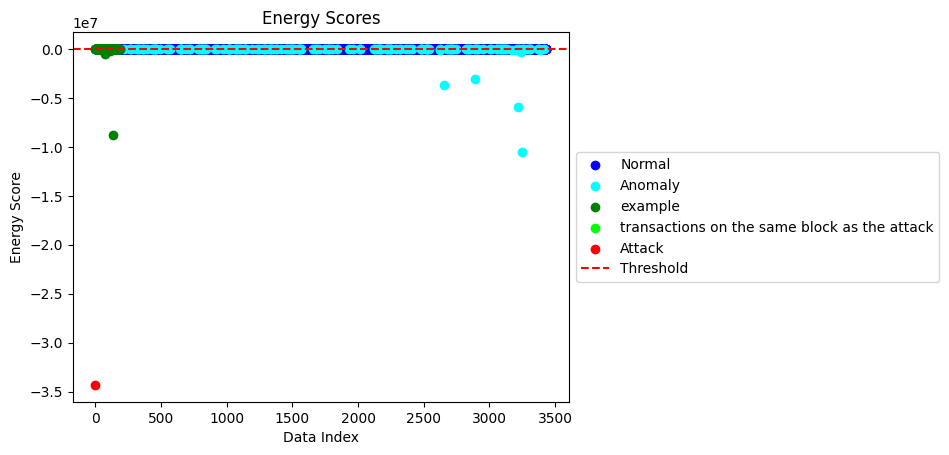

Found you
number of transactions with energy greater or equal to the attack in train is:  0  out of:  2575
number of transactions with energy greater or equal to the attack in test is:  0  out of:  859
number of transactions with energy greater or equal to the attack in example is:  0  out of:  186
true positive:  1.0
false positive:  0.9301075268817204
true negative:  0.06989247311827956
false negative:  0.0


In [ ]:
from sklearn import mixture



train_data, test_data = train_test_split(prep_data, test_size=0.25, random_state=40)

clf = mixture.BayesianGaussianMixture(n_components=1, covariance_type="full")
clf.fit(train_data)


# Get anomaly scores for test data
train_energy=clf.score_samples(train_data)
test_energy=clf.score_samples(test_data)
all_energy=np.concatenate((train_energy, test_energy), axis=0)

# Determine anomalies
threshold = np.percentile(all_energy, 5)
print(threshold)




normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

normal_indices = torch.where(normal_energy > threshold)[0]
anomaly_indices = torch.where(normal_energy <= threshold)[0]
attack = torch.tensor(clf.score_samples(anom.numpy()))
example = torch.tensor(clf.score_samples(exam.numpy()))

print(clf.score_samples(anom.numpy()))


plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
print(attack)

plt.scatter(range(len(example)), example, c='green', label='example')


plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')
plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

if(attack[0]<=threshold):
  print("Found you")
else:
  print("try again")


print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(torch.tensor(train_energy) <= attack[0])[0]), " out of: ", len(train_energy))
print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(torch.tensor(test_energy) <= attack[0])[0]), " out of: ", len(test_energy))
print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example <= attack[0])[0]), " out of: ", len(example))

false_pos=len(torch.where(example >= threshold)[0])/len(example)
true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
false_neg=len(torch.where(attack > threshold)[0])/len(attack)
true_neg=len(torch.where(example < threshold)[0])/len(example)

print('true positive: ', true_pos)
print('false positive: ', false_pos)
print('true negative: ', true_neg)
print('false negative: ', false_neg)
